# FDW Crop Production Data Analysis - Lesotho

In [1]:
import json, requests
from functools import reduce
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

## Report 1: duplicate data

In [2]:
# Reproduce duplicate data
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Lesotho',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
pub = [
    'Agricultural Production Survey Crops, 2017-2018, Lesotho', 
    'BOS, Lesotho, Statisitical Report, 2017/2018 Crop Forecasting Report, NO 21 of 2040'
]
sub = df[df['publication_name'].isin(pub)]
sub.pivot_table(index=['season_date','product','fnid'],columns=['publication_name','indicator'],values='value')

publication_name                    Agricultural Production Survey Crops, 2017-2018, Lesotho  \
indicator                                                                       Area Planted   
season_date product      fnid                                                                  
2018-08-01  Maize (Corn) LS1980A101                                            20516.0         
                         LS1980A102                                             7632.0         
                         LS1980A103                                            27259.0         
                         LS1980A104                                            20848.0         
                         LS1980A105                                            21881.0         
                         LS1980A106                                            12062.0         
                         LS1980A107                                            10114.0         
                         LS1980A108                                             3858.0         
                         LS1980A109                                             5623.0         
                         LS1980A110                                            16521.0         
            Sorghum      LS1980A101                                             3077.0         
                         LS1980A102                                             2325.0         
                         LS1980A103                                             6483.0         
                         LS1980A104                                             3054.0         
                         LS1980A105                                             6737.0         
                         LS1980A106                                             6226.0         
                         LS1980A107                                              793.0         
                         LS1980A108                                              171.0         
                         LS1980A109                                             1933.0         
                         LS1980A110                                             2120.0         
            Wheat Grain  LS1980A101                                              403.0         
                         LS1980A102                                              341.0         
                         LS1980A103                                             2205.0         
                         LS1980A105                                             1445.0         
                         LS1980A106                                              300.0         
                         LS1980A107                                             2483.0         
                         LS1980A108                                              316.0         
                         LS1980A109                                              615.0         
                         LS1980A110                                             2233.0         

publication_name                                             \
indicator                           Quantity Produced Yield   
season_date product      fnid                                 
2018-08-01  Maize (Corn) LS1980A101            8675.0  0.42   
                         LS1980A102            4075.0  0.53   
                         LS1980A103           13103.0  0.48   
                         LS1980A104            5808.0  0.28   
                         LS1980A105           13266.0  0.61   
                         LS1980A106            4872.0  0.40   
                         LS1980A107            3622.0  0.36   
                         LS1980A108            1594.0  0.41   
                         LS1980A109            2659.0  0.47   
                         LS1980A110            6980.0  0.42   
            Sorghum      LS1980A101             523.0  0.17   
                         LS1980A102          

## Report 2: Year-off issue

In [3]:
# Reproduce year-off issue
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Lesotho',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
df[
    (df['product'] == 'Maize Grain (White)') &
    (df['season_year'].isin(['Summer 2013','Summer 2014','Summer 2015','Summer 2016'])) &
    (df['indicator'] == 'Quantity Produced')
].pivot_table(index='admin_1',columns=['season_date','period_date'],values='value')

season_date,2013-08-01,2014-08-01,2015-08-01,2016-08-01
period_date,2014-01-31,2015-01-31,2016-01-31,2017-01-31
admin_1,,,,
Berea,13817.0,15515.0,6476.0,3173.0
Butha-Buthe,3180.0,2540.0,3343.0,1117.0
Leribe,13967.0,14319.0,18849.0,4285.0
Mafeteng,10069.0,10191.0,3001.0,348.0
Maseru,15671.0,15044.0,14873.0,4766.0
Mohale's Hoek,3529.0,11167.0,4068.0,1970.0
Mokhotlong,13493.0,10531.0,8197.0,3933.0
Qacha's Nek,1696.0,944.0,396.0,1607.0


## Validation with FAO-STAT

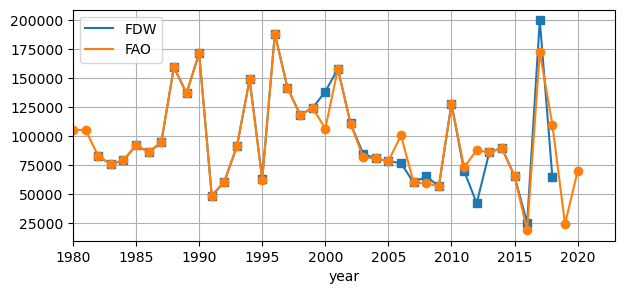

In [4]:
#%% Validation with FAO-STAT national production data
# Load GSCD crop data -------------------------------- # 
# country_iso, country_name, product_name_fdw, product_name_fao = 'LS', 'Lesotho', 'Sorghum', 'Sorghum'
country_iso, country_name, product_name_fdw, product_name_fao = 'LS', 'Lesotho', 'Maize', 'Maize (corn)'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
df = df[
    (df['product'] == product_name_fdw) &
    (df['indicator'] == 'production')
]
df['year'] = df['harvest_year']
data_fdw = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load FAO-STAT National Production Data ------------- #
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# ---------------------------------------------------- #
data = pd.concat([data_fdw, data_fao], axis=1, keys=['FDW','FAO']).sort_index()

ax = data.plot(xlim=[1980,2023],figsize=[7,3],grid=True)
marker = ['s','o']
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker[i])

## Validation with CHIRPS Precipitation

Summer-Maize Correlation:
           FDW      PRCP
FDW   1.000000  0.343068
PRCP  0.343068  1.000000


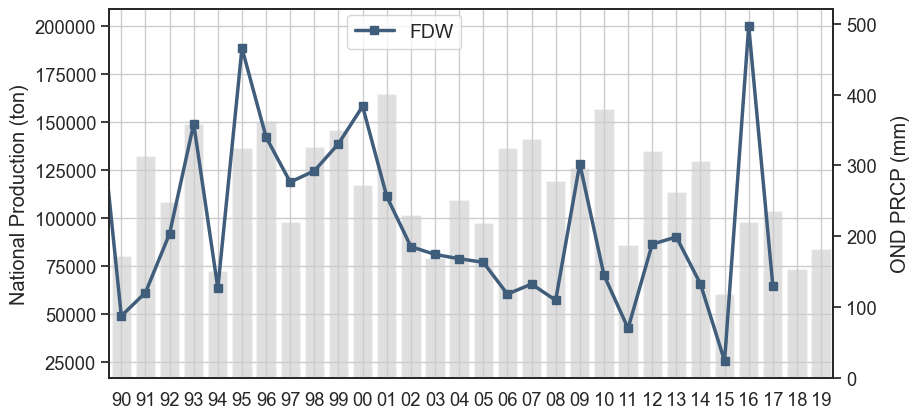

In [5]:
#%% Correlation with growing season CHIRPS precipitation
# Load GSCD crop data -------------------------------- #
country_iso, country_name = 'LS', 'Lesotho'
df = pd.read_hdf('../data/crop/adm_crop_production_%s.hdf' % country_iso)
df = df[df['gscd_code']=='calibrated']; fnids = list(df['fnid'].unique())
season_name, product_name, prcp_start_month, prcp_season_name = 'Summer', 'Maize', 10, 'OND PRCP (mm)'
df = df[
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name])) &
    (df['indicator'] == 'production')
]
df['year'] = df['planting_year']
data = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').sum(1).rename('FDW')
# ---------------------------------------------------- #

# Load precipitation --------------------------------- #
prcp = pd.read_hdf('../data/adm.prcp.chirps-v2.crop.extended.hdf')[fnids]
# prcp.index = pd.to_datetime(prcp.index)
prcp = prcp.resample('1M').agg('sum')
prcp.index = prcp.index.map(lambda x: x.replace(day=1))
assert prcp.isna().sum().sum() == 0 # if not, use FillMissMonthMean
# National seasonal precipitation
prcp_nat = prcp.mean(1).rename('PRCP')
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name} Correlation:\n{corr_value}')
# ---------------------------------------------------- #

# Validation figure ---------------------------------- #
years = np.arange(1990,2020)
sns.set(style="white", font_scale=1.2)
fig, ax1 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(9,4))
data.plot(ax=ax1, legend=None, linewidth=2.5, marker='s', color=['#405E7B','#FB6222','#17AB6F'])
ax1.set_xlim([years.min()-0.5, years.max()+0.5])
ax1.set_xticks(years)
ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.xaxis.grid(True)
ax1.grid(True)
ax1.set_xlabel('')
ax1.set_ylabel('National Production (ton)')
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label, labelpad=10)
ax1.set_zorder(1)  # default zorder is 0 for ax1 and ax2
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(bbox_to_anchor=(0.5, 1.01), columnspacing=0.7, ncol=3, fontsize=14)
plt.tight_layout(pad=0)
plt.show()
# ---------------------------------------------------- #